# Temporal Amplification

In [1]:
# import modules
import sys
sys.path.insert(1, '../src')
from MPA_model import *
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

## Pre Amplification Steps

In [36]:
# parameters for intital pulse
SIGNAL_RESOLUTION = int(100) # number of signal splits
WAVELENGTH = 1053e-9 # in meter
PULSE_ENERGY = 100e-3 # in joule
PULSE_DURATION = 10e-9 # in seconds
PULSE_SHAPE = 'interpolate'
INPUT_AREA = np.pi * (8e-3)**2 # in meter square
PAD_ZERO = True # pad zero before and after the pulse. If true, the length of signal array will be twice of SIGNAL_RESOLUTION

# additional parameters depend on pulse shape
# only needed for Gaussian pulse
FWHM = 2e-9 # full width at half maximum

# only needed for pulse shape generated using interpolation
xpoints = np.array([0, 5, 7.5, 10])
ypoints = np.array([3.5, 8.75, 7.25, 9])
#xpoints = np.array([0, 0.5, 2, 3, 3.5, 4])
#ypoints = np.array([0.3, 0.375, 0.25, 0.5, 0.825, 1])
kind = 'quadratic' # kind of interpolation

In [37]:
# initiate signal generator object
signal_generator = SignalGenerator(SIGNAL_RESOLUTION)

In [38]:
# generate initial pulse
peak_power = signal_generator.calculate_peak_power(PULSE_DURATION, PULSE_ENERGY, PULSE_SHAPE, FWHM = FWHM, xpoints = xpoints, ypoints = ypoints, kind = kind, pad_zero = PAD_ZERO)
initial_time, initial_power_t = signal_generator.generate_signal(PULSE_DURATION, peak_power, PULSE_SHAPE, FWHM = FWHM, xpoints = xpoints, ypoints = ypoints, kind = kind, pad_zero = PAD_ZERO)

In [39]:
dt = initial_time[1] - initial_time[0] # time step
initial_amp_t = np.sqrt(initial_power_t) # convert to amplitude

# pack time series single to signal_pile
initial_signal_pile = pack_signal_pile([WAVELENGTH], [initial_amp_t], INPUT_AREA, dt)

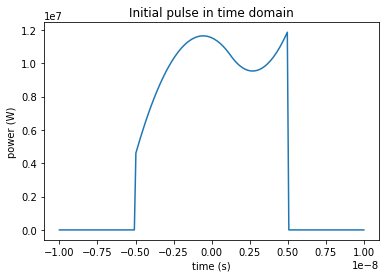

In [40]:
# plot the shape of initial pulse in time domain
plt.plot(initial_time, initial_power_t)
plt.title('Initial pulse in time domain')
plt.xlabel('time (s)')
plt.ylabel('power (W)')
plt.show()

## Amplification Steps

### Amplification in Crystal 1

In [7]:
# crystal 1 parameters
CRYSTAL1_ALPHA = np.infty # attenuation in 
CRYSTAL1_QD = 1 # quantum defect
CRYSTAL1_LENGTH = 40e-2 # length in meter
CRYSTAL1_N2 = 0 # nonlinear refractive index in m^2/W
CRYSTAL1_J_SAT = 5e4 # saturation fluence in J/m^2

# initiate crystal 1 object
crystal1 = Crystal(CRYSTAL1_ALPHA, CRYSTAL1_QD, CRYSTAL1_LENGTH, CRYSTAL1_N2, CRYSTAL1_J_SAT)

In [8]:
# pump energy parameters
PUMP1_ENERGY = 44.26 # in joule
PUMP1_AREA =  np.pi * (8e-3)**2 # in meter square
PUMP1_ENERGY_DISTRIBUTION = 'uniform'
PUMP1_FRONT_PUMP = True
PUMP1_BACK_PUMP = False

# initiate pump 1 object
pump1 = Pump(PUMP1_ENERGY, PUMP1_AREA)

In [9]:
# multipass amplifier (MPA) 1 parameters
MPA1_CRYSTAL_RESOLUTION = 10 # number of crystal splits
MPA1_NUMPASS = 1 # number of passes
MPA1_LOSS_PER_PATH = 0 # percent of energy loss per path

#initiate MPA 1 
m1 = MultiPassAmplifier(crystal1)
m1.set_crystal_res(MPA1_CRYSTAL_RESOLUTION)
m1.set_loss_per_path(MPA1_LOSS_PER_PATH)
m1.clear_passes()

In [10]:
# calculate stored energy 
store1 = m1.calculate_stored_energy_from_pump(pump1, PUMP1_ENERGY_DISTRIBUTION, front_pump = PUMP1_FRONT_PUMP, back_pump = PUMP1_BACK_PUMP)

In [11]:
# amplify the signal
m1.calculate_multi_pass_amplification(store1, initial_signal_pile, MPA1_NUMPASS)
after_crystal1_signal_pile = m1.get_single_pass_output()

In [12]:
# calculate pulse energy after amplification in crystal 1
m1.get_total_energy_signal_pile(after_crystal1_signal_pile)

6.000194681736924

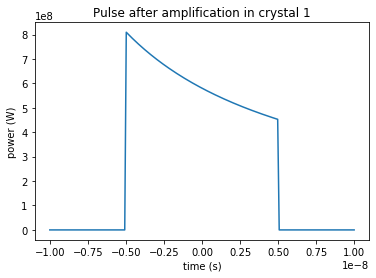

In [13]:
# unpack signal pile back to time series
after_crystal1_amp_t = unpack_signal_pile(after_crystal1_signal_pile, dt)[0]
after_crystal1_power_t = np.absolute(after_crystal1_amp_t) **2

# plot the shape of initial pulse in time domain
plt.plot(initial_time, after_crystal1_power_t)
plt.title('Pulse after amplification in crystal 1')
plt.xlabel('time (s)')
plt.ylabel('power (W)')
plt.show()

### Split pulse into multiple beams

In [14]:
# split parameters
NUM_SPLIT = 4
ENERGY_MULTIPLIER = 1/NUM_SPLIT
AREA_MULTIPLIER = 2

# initiate signal manipulator
signal_manip = SignalManipulator()
after_split_signal_pile = signal_manip.manipulate_signal_pile(after_crystal1_signal_pile, ENERGY_MULTIPLIER, 0, AREA_MULTIPLIER, 0)

In [15]:
# calculate pulse energy after split
m1.get_total_energy_signal_pile(after_split_signal_pile)

1.500048670434231

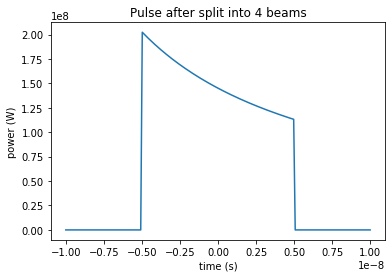

In [16]:
# unpack signal pile back to time series
after_split_amp_t = unpack_signal_pile(after_split_signal_pile, dt)[0]
after_split_power_t = np.absolute(after_split_amp_t) **2

# plot the shape of initial pulse in time domain
plt.plot(initial_time, after_split_power_t)
plt.title('Pulse after split into 4 beams')
plt.xlabel('time (s)')
plt.ylabel('power (W)')
plt.show()

### Amplification in Crystal 2

In [17]:
# crystal 2 parameters
CRYSTAL2_ALPHA = np.infty # attenuation in 
CRYSTAL2_QD = 1 # quantum defect
CRYSTAL2_LENGTH = 15e-3 # length in meter
CRYSTAL2_N2 = 0 # nonlinear refractive index in 1/W^2
CRYSTAL2_J_SAT = 5e4 # saturation fluence

# initiate crystal 2 object
crystal2 = Crystal(CRYSTAL2_ALPHA, CRYSTAL2_QD, CRYSTAL2_LENGTH, CRYSTAL2_N2, CRYSTAL2_J_SAT)

In [18]:
# pump energy parameters
PUMP2_ENERGY = 100 # in joule
PUMP2_AREA = np.pi * (16e-3)**2 # in meter square
PUMP2_ENERGY_DISTRIBUTION = 'uniform'
PUMP2_FRONT_PUMP = True
PUMP2_BACK_PUMP = False

# initiate pump 1 object
pump2 = Pump(PUMP2_ENERGY, PUMP2_AREA)

In [19]:
# multipass amplifier (MPA) 2 parameters
MPA2_CRYSTAL_RESOLUTION = 10 # number of crystal splits
MPA2_NUMPASS = 1 # number of passes
MPA2_LOSS_PER_PATH = 0 # percent of energy loss per path

# initiate MPA 2
m2 = MultiPassAmplifier(crystal2)
m2.set_crystal_res(MPA2_CRYSTAL_RESOLUTION)
m2.set_loss_per_path(MPA2_LOSS_PER_PATH)
m2.clear_passes()

In [20]:
# calculate stored energy 
store2 = m2.calculate_stored_energy_from_pump(pump2, PUMP2_ENERGY_DISTRIBUTION, front_pump = PUMP2_FRONT_PUMP, back_pump = PUMP2_BACK_PUMP)

In [21]:
# amplify the signal
m2.calculate_multi_pass_amplification(store2, after_split_signal_pile, MPA2_NUMPASS)
after_crystal2_signal_pile = m2.get_single_pass_output()

In [22]:
# calculate pulse energy after amplification in crystal 2
m2.get_total_energy_signal_pile(after_crystal2_signal_pile)

15.111545373590722

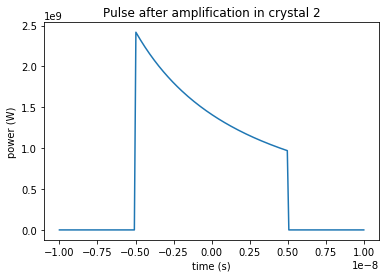

In [23]:
# unpack signal pile back to time series
after_crystal2_amp_t = unpack_signal_pile(after_crystal2_signal_pile, dt)[0]
after_crystal2_power_t = np.absolute(after_crystal2_amp_t) **2

# plot the shape of initial pulse in time domain
plt.plot(initial_time, after_crystal2_power_t)
plt.title('Pulse after amplification in crystal 2')
plt.xlabel('time (s)')
plt.ylabel('power (W)')
plt.show()

### Recombine beams

In [24]:
NUM_RECOMBINE = 4
after_recombine_signal_pile = signal_manip.multiply_energy_signal_pile(after_crystal2_signal_pile, NUM_RECOMBINE)

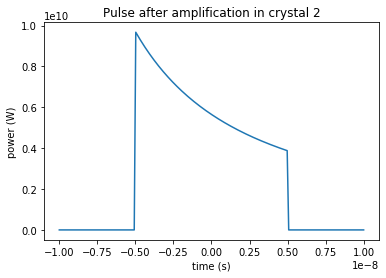

In [25]:
# unpack signal pile back to time series
after_recombine_amp_t = unpack_signal_pile(after_recombine_signal_pile, dt)[0]
after_recombine_power_t = np.absolute(after_recombine_amp_t) **2

# plot the shape of initial pulse in time domain
plt.plot(initial_time, after_recombine_power_t)
plt.title('Pulse after amplification in crystal 2')
plt.xlabel('time (s)')
plt.ylabel('power (W)')
plt.show()

## Post Amplification Steps

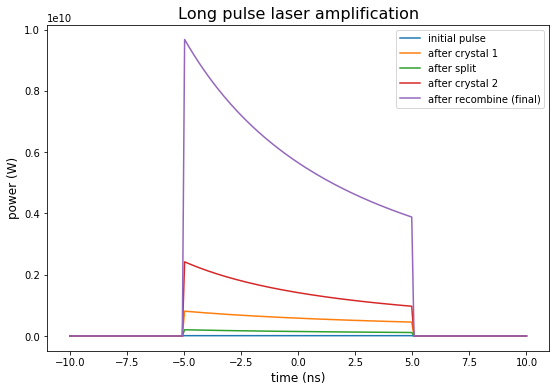

In [26]:
# plot all pulse together
plt.figure(figsize = (9, 6))
plt.plot(initial_time*1e9, initial_power_t, label = 'initial pulse')
plt.plot(initial_time*1e9, after_crystal1_power_t, label = 'after crystal 1')
plt.plot(initial_time*1e9, after_split_power_t, label = 'after split')
plt.plot(initial_time*1e9, after_crystal2_power_t, label = 'after crystal 2')
plt.plot(initial_time*1e9, after_recombine_power_t, label = 'after recombine (final)')
plt.title('Long pulse laser amplification', fontsize = 16)
plt.xlabel('time (ns)', fontsize = 12)
plt.ylabel('power (W)', fontsize = 12)
plt.legend()
plt.show()

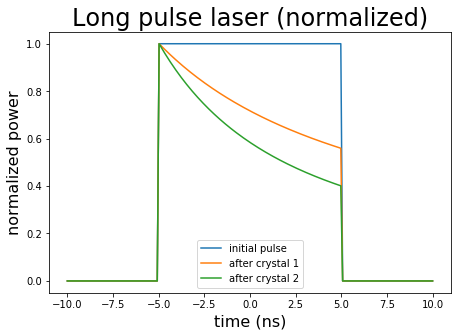

In [27]:
# normalized plot
plt.figure(figsize = (9/1.25, 6/1.25))
plt.plot(initial_time*1e9, initial_power_t/np.amax(initial_power_t), label = 'initial pulse')
plt.plot(initial_time*1e9, after_crystal1_power_t/np.amax(after_crystal1_power_t), label = 'after crystal 1')
plt.plot(initial_time*1e9, after_crystal2_power_t/np.amax(after_crystal2_power_t), label = 'after crystal 2')
plt.title('Long pulse laser (normalized)', fontsize = 24)
plt.xlabel('time (ns)', fontsize = 16)
plt.ylabel('normalized power', fontsize = 16)
plt.legend(loc = 'best')
#plt.tight_layout()
plt.savefig('../pics/long_input1.png', quality = 95, dpi = 600)
plt.show()

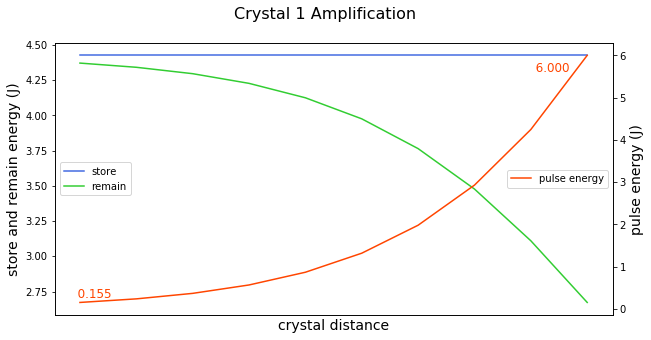

In [28]:
store_data = m1.plot_multi_pass_store_energy()
remain_data = m1.plot_multi_pass_remain_energy()

output_data = m1.plot_multi_pass_output_energy()

fig, ax1 = plt.subplots(figsize = (10,5))

plot_multi_pass_data(ax1, MPA2_NUMPASS, [store_data, remain_data], ['royalblue', 'limegreen'], ['store', 'remain'], 1e2, 1, 'center left')
ax1.set_xlabel('crystal distance', fontsize  = 14)
ax1.set_ylabel('store and remain energy (J)', fontsize = 14)
ax1.get_xaxis().set_ticks([])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

plot_multi_pass_data(ax2, MPA2_NUMPASS, [output_data], ['orangered'], ['pulse energy'], 1e2, 1, 'right')
ax2.set_ylabel('pulse energy (J)', fontsize = 14)

output_x, output_y = output_data
val = output_y[0]
ax2.text(output_x[0] - 1, val + 0.1, "{0:8.3f}".format(val), c = 'orangered', fontsize = 12)
plot_multi_pass_last_value(ax2, MPA2_NUMPASS, output_data, 'orangered', '{0:8.3f}', 1e2, 1, -4.5, -0.4, 12)

fig.suptitle('Crystal 1 Amplification', fontsize = 16)
fig.savefig('../pics/long_MPA1.png')
plt.show()

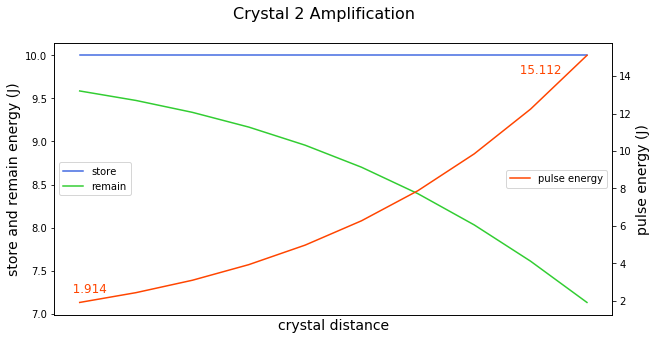

In [29]:
store_data = m2.plot_multi_pass_store_energy()
remain_data = m2.plot_multi_pass_remain_energy()

output_data = m2.plot_multi_pass_output_energy()

fig, ax1 = plt.subplots(figsize = (10,5))

plot_multi_pass_data(ax1, MPA2_NUMPASS, [store_data, remain_data], ['royalblue', 'limegreen'], ['store', 'remain'], 1e2, 1, 'center left')
ax1.set_xlabel('crystal distance', fontsize  = 14)
ax1.set_ylabel('store and remain energy (J)', fontsize = 14)
ax1.get_xaxis().set_ticks([])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

plot_multi_pass_data(ax2, MPA2_NUMPASS, [output_data], ['orangered'], ['pulse energy'], 1e2, 1, 'right')
ax2.set_ylabel('pulse energy (J)', fontsize = 14)

output_x, output_y = output_data
val = output_y[0]
ax2.text(output_x[0] - 0.05, val + 0.5, "{0:8.3f}".format(val), c = 'orangered', fontsize = 12)
plot_multi_pass_last_value(ax2, MPA2_NUMPASS, output_data, 'orangered', '{0:8.3f}', 1e2, 1, -0.2, -1, 12)

fig.suptitle('Crystal 2 Amplification', fontsize = 16)
fig.savefig('../pics/long_MPA2.png')
plt.show()